# Deep Learning tutorial #1

# Clasificación MNIST con Keras

by [Pedro Fernando Rodenas Perez](https://pedrofrodenas.github.io) / [GitHub](https://github.com/PedrofRodenas)


### Introducción

Keras es una biblioteca de código abierto escrita en Python. Se ejecuta sobre [TensorFlow](https://www.tensorflow.org). Su uso facilita mucho la implementación de redes neuronales profundas, permitiendo crear modelos complejos en poco tiempo y minimizando los errores. Es una API muy desarrollada y con una documentación excelente. Actualmente se sigue desarrollando.


### Diagrama de flujo

<img src="net.png" width="500">



La imagen de entrada se procesa en la primera capa convolucional usando los pesos de filtro. Esto da como resultado 16 nuevas imágenes, una para cada filtro en la capa convolucional. Las imágenes también sub-muestrean, por lo que la resolución de los mapas de características se reduce de [28x28] a [14x14].
La tercera capa consta de 36 filtros convolucionales con dimensiones [14x14x16], dando lugar a 36 mapas de características de dimensiones [14x14].   
Se aplica de nuevo una capa de sub-muestreo, bajando la resolución de los anteriores mapas de características de [14x14] a [7x7]. Quedando con dimension el conjunto de mapas [7x7x36].  
Finalmente se alisan todos los mapas de características de la capa anterior formando un vector de dimensiones [1, 7x7x36] --> [1, 1764].  
Este vector se usa como entrada a la capa Fully-Connected con 128 neuronas del tipo Perceptrón Multicapa.  
La salida de esta capa compone la entrada de la siguiente capa fully-connected con 10 neuronas, una para cada una de las clases, que se usa para determinar la clase de la imagen, es decir, qué número se representa en la imagen.


Los pesos de los filtros convolucionales se eligen inicialmente al azar, por lo que la clasificación se realiza al azar. El error entre la clase predicha y la verdadera de la imagen de entrada se mide como entropía cruzada. El optimizador luego propaga automáticamente este error a través de la red convolucional usando la regla de la cadena de diferenciación y actualiza los pesos del filtro para mejorar el error de clasificación. Esto se hace iterativamente miles de veces hasta que el error de clasificación sea suficientemente bajo.

Tenga en cuenta que el cálculo en TensorFlow no se realiza de imagen en imagen sino que se calcula para un conjunto de imagenes, este conjunto se denomina batch size. Esta manera de entrenar la red hace que el cálculo sea más eficiente. Esto significa que el diagrama de flujo en realidad tiene una dimensión de datos más cuando se implementa en TensorFlow.

### Convolucion
La operación de convolución discreta espacial se define como:  

$$c[m,n] = I[m,n]\otimes W[m,n] = \sum_{j=0}^{J-1}{\sum_{k=0}^{K-1}{W(j,k)I(m-j, n-k)}}$$

Donde:
* I es la imagen a procesar
* W es el filtro convolucional o kernel
* C es la imagen resultado de la convolución

Visto gráficamente:

<img src="Imagen1.png" width="400">

El tamaño de paso para mover el filtro a través de la imagen de entrada se llama stride. Hay un stride para mover el filtro horizontalmente (eje x) y otro paso para moverse verticalmente (eje y).  
En el siguiente tutorial se establece en 1 el stride en ambas direcciones, lo que significa que el filtro comienza en la esquina superior izquierda de la imagen de entrada y se mueve 1 píxel a la derecha en cada paso. Cuando el filtro llega al borde derecho de la imagen, el filtro vuelve al lado izquierdo y 1 píxel hacia abajo. Esto continúa hasta que el filtro haya alcanzado la esquina inferior derecha de la imagen de entrada y se haya generado toda la imagen de salida.

Hay que tener en cuenta que para que el resultado de la convolución tenga el mismo tamaño que la imagen de entrada hay que rellenar los bordes con ceros. Sino la imagen de salida tendrá menor tamaño. La siguiente ecuación muestra el tamaño de la imagen de salida en función de los parámetros comentados:


$$ R = \frac{W-K+2P}{S}+1$$

Donde:

* W tamaño imagen entrada
* K tamaño del filtro
* P es la cantidad de 0's añadidos en un borde
* S es el stride 
* R es el tamaño del resultado de la convolución

Además, la salida de la convolución se puede pasar a través de una funcion de activación llamada Rectified Linear Unit (ReLU), que simplemente garantiza que la salida sea positiva porque los valores negativos se establecen en cero. 
La salida de una capa convolucional tambien puede ser sub-muestreada, que es conocido como pooling.
#### Pooling
Se aplica una ventana deslizante con un determinado stride como en la convolución pero esta toma los píxeles que caen dentro de ella y realiza algún tipo de operación lineal o no lineal. La más utilizada es conocida como Max-Pooling y toma el pixel que tiene más valor dentro de la ventana y lo coloca en la imagen de salida.  
En la imagen siguiente se muestra la operación de pooling o sub-muestreo del tipo max-pooling. Con un stride de 2 para el eje horizontal y 2 para el eje vertical, tambien representado como stride = [2, 2].

<img src="Imagen2.png" width="400">

Nota que la imagen de salida tiene la mitad de tamaño que la imagen de entrada.


Ahora que se ha comentado las operaciones principales que realizan este tipo de arquitecturas vamos con el código.


### Importación de librerias

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from random import sample
from keras.models import Sequential
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten
from keras.layers import InputLayer
from keras.optimizers import Adam

Using TensorFlow backend.


### Descarga de la base de datos MNIST

Nota que al ser una base de datos tan popular ya existen scripts para descargar, descomprimir y formar el conjunto de datos de entreno y de test. En un caso real, hay que programar las funciones que se encarguen de la descarga, la importación, la unificación de las imagenes para que todas tengan el mismo tamaño, etc... Este paso normalmente es de los que ocupan más tiempo.

In [2]:
# Para descargar la base de datos MNIST
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


El conjunto de datos MNIST ahora se ha cargado y consiste en 70,000 imágenes y números de clase para las imágenes. El conjunto de datos se divide en 3 subconjuntos. Uno se utiliza para entrenar la red, otro para testearla y otro para validar que el entreno se este realizando correctamente.  

In [3]:
print("Tamaño de:")
print("- Set de entreno:\t{}".format(len(mnist.train.labels)))
print("- Set de test:\t\t{}".format(len(mnist.test.labels)))
print("- Set de validación:\t{}".format(len(mnist.validation.labels)))

Tamaño de:
- Set de entreno:	55000
- Set de test:		10000
- Set de validación:	5000


MNIST contiene imagenes de números manuscritos que van desde el 0 hasta el 9, por tanto tenemos 10 clases a clasificar. Las imagenes se almacenan en un vector y las etiquetas en otro.   
Las etiquetas sirven para decirle a la red que número es una determinada imagen a la hora de entrenar. En la fase de test sirven para comprobar si la red neuronal ha clasificado bien un determinado número.

Ahora se va asignar a variables datos como el tamaño de las imágenes, el número de imagenes etc... Estos datos se usarán posteriormente.

In [4]:
# Numero de píxeles en cada dimension de la imagen
img_size = 28

# Las imagenes se almacenan en un vector de una dimensión de este tamaño
img_size_flat = img_size*img_size

# Numero de canales de color de las imagenes. Como son de escala de grises sólo tienen 1 canal
num_channels = 1

# Numero de clases, como son digitos que van desde el 0 al 9
num_classes = 10

# Lista con el tamaño de la imagen de la forma [altura, anchura] = [img_size, img_size]  
img_shape = (img_size, img_size)

# Lista con altura, anchura y profundidad de las imagenes [altura, anchura, canales_color]
img_shape_full = (img_size, img_size, 1)

### Guardar los datos de MNIST en diferentes variables

Las etiquetas que indican qué número es una imagen se almacenan en vectores de 0's en el que la posición que contiene un 1 indica de que número se trata. Este tipo de codificación se denomina _one hot_

Por ejemplo el número 5 se codifica de la siguiente manera:


$$5 = \begin{bmatrix}
0 &  0& 0 & 0 & 0 &1  & 0 &0  & 0 & 0
\end{bmatrix}$$


Nota que en la posición 5 del vector (empezando a contar por 0) se coloca el 1 indicando que se trata del número 5.
Para obtener el entero a partir del vector se utiliza la función **numpy.argmax()**



In [5]:
# Guardar las imagenes y etiquetas de entreno
images_train = mnist.train.images
labels_train = mnist.train.labels

# Guardar las imagenes y etiquetas de test
images_test = mnist.test.images
labels_test = mnist.test.labels

### Función auxiliar para plotear imagenes

La siguiente función sirve para plotear 9 ejemplos de la base de datos MNIST, y indicar que número se trata. En el caso que se le pase lo que ha predicho la red ploteará las imágenes predichas correctamente con un marco verde y las mal predichas con un rectángulo rojo.

In [18]:
def plot_imagenes(imagenes, verdaderas, predichas=None):
    
    # Seleccionar 9 indices aleatorios para elegir las imagenes
    ind = sample(range(len(imagenes)),9)
    
    # Tomar las imagenes
    img = imagenes[ind]
    
    color = 'green'
    
    # Tomar las etiquetas verdaderas y predichas si las hay
    if predichas is None:
        etiq = verdaderas[ind]
    else:
        etiq = verdaderas[ind]
        pred = predichas[ind]
         
    # Crear la figura con 3x3 sub-plots
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plotear imagen.
        ax.imshow(img[i].reshape(img_shape), cmap='binary')

        # Mostrar los numeros verdaderos y predichos
        if predichas is None:
            xlabel = "Numero: {0}".format(etiq[i])
        else:
            xlabel = "Numero: {0}, Predicho: {1}".format(etiq[i], pred[i])
            
            
            if etiq[i] != pred[i]:
                color = 'red'
            
            ax.spines['bottom'].set_color(color)
            ax.spines['top'].set_color(color)
            ax.spines['left'].set_color(color)
            ax.spines['right'].set_color(color)

        # Mostrar los numeros en el eje x
        ax.set_xlabel(xlabel)
        
        # Borrar los ticks del plot
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Plotear varias imágenes para comprobar que los datos son correctos

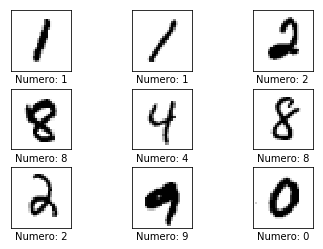

In [7]:
# Tomar las imagenes del conjunto de test
images = mnist.test.images

# Tomar las etiquetas del conjunto de test
true_labels = mnist.test.labels

# Pasar de la codificacion one hot para obtener la etiqueta en formato entero
true_cls = np.argmax(true_labels, axis=1)

# Plotear las imagenes y sus etiquetas
plot_imagenes(imagenes=images, verdaderas=true_cls)

### Función auxiliar para plotear las imagenes mal clasificadas
La siguiente función se utiliza para ver las imagenes que se han clasificado incorrectamente. Es útil realizar este paso para observar que es lo que está confundiendo a la red y aplicar un preprocesado a la base de datos si fuera necesario para tratar de corregirlo.  
Se va a comparar las etiquetas que nos proporciona la base de datos con las predichas con la red neuronal a ver si coinciden.

In [29]:
def plot_misclasification(pred_cls, true_cls):
    # pred_cls son las etiquetas predichas con la red
    # true_cls son las etiquetas verdaderas 

    # Array booleano indicando si coinciden para cada posicion
    incorrectas = (pred_cls != true_cls)

    # El vector incorrectas sirve como indice para obtener todas las imagenes
    # del conjunto test que han sido clasificadas incorrectamente
    images = images_test[incorrectas]
    
    # Obtener las clases predecidas para esas imagenes
    pred_cls = pred_cls[incorrectas]

    # Obtener las clases verdaderas para esas imagenes
    verd = true_cls[incorrectas]
    
    # Ploteamos esas imagenes usando la funcion auxiliar definida anteriormente
    plot_imagenes(imagenes=images, verdaderas=verd, 
                  predichas=pred_cls)

### Construcción de red neuronal

Keras dispone de dos modos para construir una arquitectura de red, el **sequential mode** y el **functional mode**. En este tutorial usaremos el sequential mode que es el más simple.  
En el sequential mode se añaden capas de neuronas para formar la arquitectura neuronal. En la primera capa se deben especificar las dimensiones de los datos de entrada.  
En nuestro caso las imagenes se encuentran en un vector de una fila y 28*28 columnas. Una vez introducido el vector a la red hay que modificarlo para que se realice la convolución correctamente. Transformando el vector de [1, 784] a una matriz de [28, 28] que es la imagen que se puede visualizar.  

In [9]:
# Llamamos al constructor del modelo sequential
model = Sequential()

# Añadimos la capa de entrada especificando el formato
# en el que se encuentran los datos de entrada
model.add(InputLayer(input_shape=(img_size_flat,)))

# Modificar el vector de 784 elementos para formar 
# la imagen de (28, 28, 1)
model.add(Reshape(img_shape_full))

# Primera capa convolucional con funcion de activacion ReLU y max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                 activation='relu', name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Segunda capa convolucional con funcion de activacion ReLU y max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Se convierte a un vector la salida de la capa anterior.
# El vector tendra de dimensiones [1, 1764]
model.add(Flatten())

# Capa fully-connected. Tambien conocidas como Dense
model.add(Dense(128, activation='relu'))

# Ultima capa de la red, del tipo Dense. Nota que hay 
# num_classes=10 neuronas en esta capa. La clasificacion
# se hara comprobando que neurona obtiene a la salida un 
# numero mayor.
model.add(Dense(num_classes, activation='softmax'))

### Comprobar la estructura de la red

Para comprobar la estructura de la red y el número de parámetros entrenables usamos la siguiente sentencia.

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1764)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               225920    
__________

### Compilación del modelo

Se ha definido la estructura de la red neuronal convolucional, ahora hay que añadir el tipo de optimizador y las métricas que se van a utilizar.  
Los modelos de Deep Learning generalmente son entrenados por un optimizador de descenso de gradiente estocástico. Hay muchas variaciones de descendencia de gradiente estocástica: Adam, RMSProp, Adagrad, etc. Todas permiten establecer el **learning rate**.  
Cuando más pequeño sea este parámetro más tardará la red en entrenar y más precisión se obtendrá para el conjunto de datos de entreno. Hay que elegir un _learning rate_ optimo para cada problema de Deep Learning. Si es muy pequeño la red aprenderá del ruido que hay en todas las imágenes y no de la función subyacente que relaciona las entradas y las salidas.  
Cuando se da este problema se obtiene una gran precisión para el conjunto de datos de entreno y disminuye para el de test porque la red se ha especializado en reconocer el conjunto de datos para el que ha sido entrenada y ha perdido la habilidad de generalizar para otros casos. Este problema se conoce como **overfitting**

In [11]:
optimizer = Adam(lr=1e-3)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Entreno

Ahora que ya se ha definido la estructura de red, el optimizador, learning rate y metricas ya se puede entrenar la red.  
Mientras se va entrenando la red aparece la cantidad de épocas o **_epoch_** completadas. Una época o _epoch_ es cuando la red ha visto todas las imagenes que contiene la base de datos. El número de epocas será otro hiperparámetro a elegir.  
No es posible entrenar la red pasandole todas las imágenes a la vez porque la memoria RAM es un recurso limitado.  
Por tanto se le pasan en grupos de un determinado número de imagenes conocido como **batch size**, cuento más grande sea este parámetro menos se tardará en completar el entreno. El **batch size** estrá limitado por la memoria RAM del computador.


In [12]:
model.fit(x=images_train,
          y=labels_train,
          epochs=1, batch_size=128)

Epoch 1/1
55000/55000 [==============================] - 68s 1ms/step - loss: 0.2281 - acc: 0.9332


El parámtro **acc** es la precisión que ha obtenido la red para el conjunto de entreno.  
Ahora hay que comprobar si clasifica bien las imágenes del conjunto de test. Estas imágenes aún no las ha visto la red y no tiene información de ellas.

### Evaluación de la red

Para ver si la red ha aprendido a clasificar bien los números manuscritos hay que comprobar la precisión que obtiene en el conjunto de datos de test. Para este conjunto no ha sido entrenada la red.

In [13]:
result = model.evaluate(x=images_test,
                        y=labels_test)

10000/10000 [==============================] - 5s 511us/step


In [14]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.07200780406584963
acc 0.9764


### Predecir y mostrar algunos ejemplos


In [15]:
y_pred = model.predict(x = images_test)

El numero predicho por la red se encuentra codificado en **one_hot** hay que convertirlo a entero para ver el resultado.

In [16]:
num_pred = np.argmax(y_pred, axis=1)

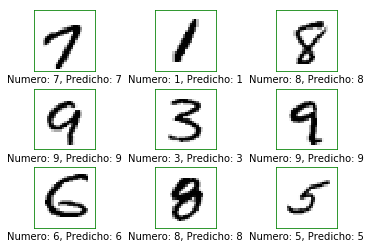

In [23]:
plot_imagenes(imagenes=images_test,
              verdaderas=true_cls,
              predichas=num_pred)

### Ver las que se han clasificado incorrectamente

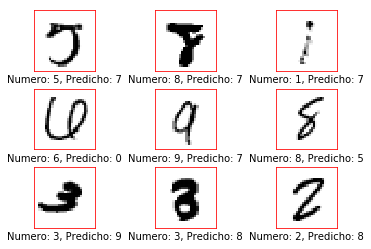

In [33]:
plot_misclasification(pred_cls=num_pred, true_cls=true_cls)

### Guardar el modelo

Es útil gurdar un modelo que ha sido entrenado satisfactoriamente para su posterior uso. De esta manera no hay que entrenar de nuevo la red y se pueden realizar prediciones con el modelo guardado.
NOTA: Será necesario instalar el paquete h5py para poder guardar modelos.

In [34]:
# Definir la carpeta donde se guarda el modelo y su nombre.
# En este caso se guarda en el mismo directorio que contiene este script
nombre_model = 'modelo.keras'

# Guardamos el modelo y todos los pesos entrenados
model.save(nombre_model)

In [35]:
# Borramos el modelo de memoria si no se va a utilizar mas
del model